<a href="https://colab.research.google.com/github/harbidel/Variational-Autoencoder/blob/main/Variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import tensorflow as tf
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir /content/celeba

In [ ]:
#!unzip /content/drive/MyDrive/img_align_celeba.zip -d /content/celeba

Streaming output truncated to the last 5000 lines.
  inflating: /content/celeba/img_align_celeba/img_align_celeba/003938.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._003938.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/025041.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._025041.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/005391.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._005391.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/012835.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._012835.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/023430.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img_align_celeba/._023430.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/020139.jpg  
  inflating: /content/celeba/__MACOSX/img_align_celeba/img

In [ ]:

import pathlib
data_dir = pathlib.Path('/content/celeba/img_align_celeba')
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle=False)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [128, 128])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = tf.cast(img, 'float32')/255.
  return img, img

proc_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = proc_ds.take(20000).cache().batch(64, drop_remainder=True)
valid_ds = proc_ds.take(10000).cache().batch(64, drop_remainder=True)


In [ ]:
# Module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, UpSampling2D, Reshape
from IPython import display
from tensorflow import keras
import tensorflow_probability as tfp
tfpl = tfp.layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

%matplotlib inline


# Task 1 - Reparameterisation layer

In [ ]:

class latent_sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    z = mean + K.exp(log_var / 2) * epsilon
    self.add_loss(-0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var)))
    self.add_metric(-0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var)), name='kl_loss')
    return z

# Task 2 - Model Definitions

In [ ]:

class encoder(layers.Layer):

    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.latent_sampling = latent_sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        z = self.latent_sampling((mean, log_var))
        return mean, log_var, z



In [ ]:

class decoder(layers.Layer):

    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


In [ ]:


class VARIATIONALAUTOENCODER(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VARIATIONALAUTOENCODER, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        mean, log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            log_var - tf.square(mean) - tf.exp(log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

# Task 3 - Train the model

In [ ]:
# Provided here are the loss functions for the VAE model.

def recon_loss(y_true, y_pred):
    recon = tf.reduce_sum(tf.square(y_true-y_pred), axis=(1,2,3))
    return tf.reduce_mean(recon)

In [ ]:
VAE = VARIATIONALAUTOENCODER(3, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

VAE.compile(optimizer, loss=recon_loss, metrics=['accuracy']) 

In [ ]:
history =VAE.fit(train_ds, epochs=5, batch_size=28)

Epoch 1/5
312/312 [==============================] - 52s 168ms/step - loss: 4326.0903 - accuracy: 0.7344 - kl_loss: 22.7678
Epoch 2/5
312/312 [==============================] - 52s 166ms/step - loss: 4335.7446 - accuracy: 0.7344 - kl_loss: 32.4156
Epoch 3/5
312/312 [==============================] - 52s 165ms/step - loss: 4366.9302 - accuracy: 0.7344 - kl_loss: 63.6156
Epoch 4/5
312/312 [==============================] - 51s 165ms/step - loss: 4394.2007 - accuracy: 0.7344 - kl_loss: 90.8957
Epoch 5/5
312/312 [==============================] - 52s 166ms/step - loss: 4426.9683 - accuracy: 0.7344 - kl_loss: 123.6693


# Task 4 - Analyse the Model

<ipython-input-36-a975926803c6>:20: MatplotlibDeprecationWarning: Unrecognized location ' upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc=' upper right')


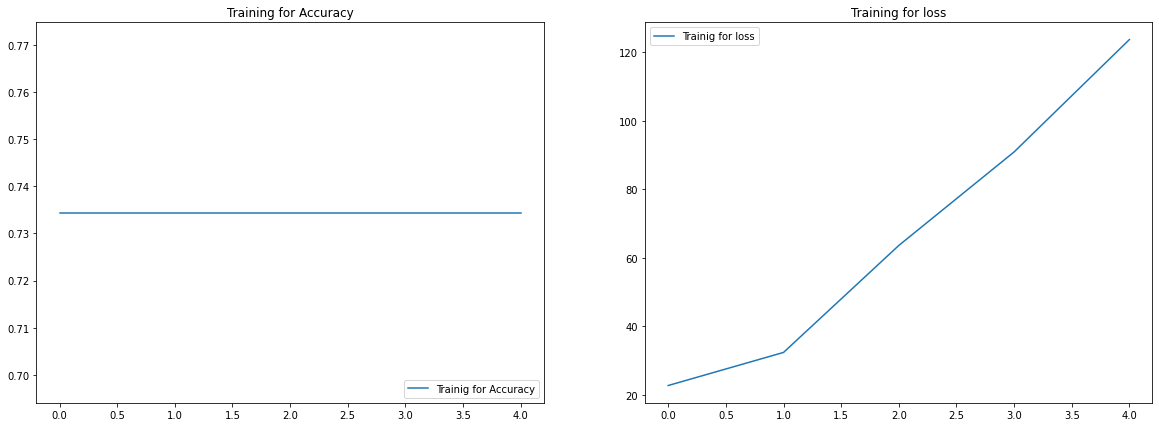

In [ ]:
accurate = history.history['accuracy']

loss = history.history['kl_loss']

epochs_range = range(5)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(epochs_range, accurate, label='Trainig for Accuracy')
plt.legend(loc='lower right')
plt.title('Training for Accuracy')


plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Trainig for loss')
plt.legend(loc=' upper right')
plt.title('Training for loss')
plt.show()


In [ ]:


history = VAE.fit(valid_ds, epochs=5, batch_size=64)

Epoch 1/5
156/156 [==============================] - 26s 165ms/step - loss: 4459.8267 - accuracy: 0.7333 - kl_loss: 147.6530
Epoch 2/5
156/156 [==============================] - 26s 164ms/step - loss: 4516.1538 - accuracy: 0.7333 - kl_loss: 204.0531
Epoch 3/5
156/156 [==============================] - 26s 164ms/step - loss: 4480.7920 - accuracy: 0.7333 - kl_loss: 168.6140
Epoch 4/5
156/156 [==============================] - 26s 167ms/step - loss: 4510.1699 - accuracy: 0.7333 - kl_loss: 197.9263
Epoch 5/5
156/156 [==============================] - 26s 164ms/step - loss: 4518.4048 - accuracy: 0.7333 - kl_loss: 206.1058


<ipython-input-38-e52e5ca497ee>:16: MatplotlibDeprecationWarning: Unrecognized location ' upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc=' upper right')


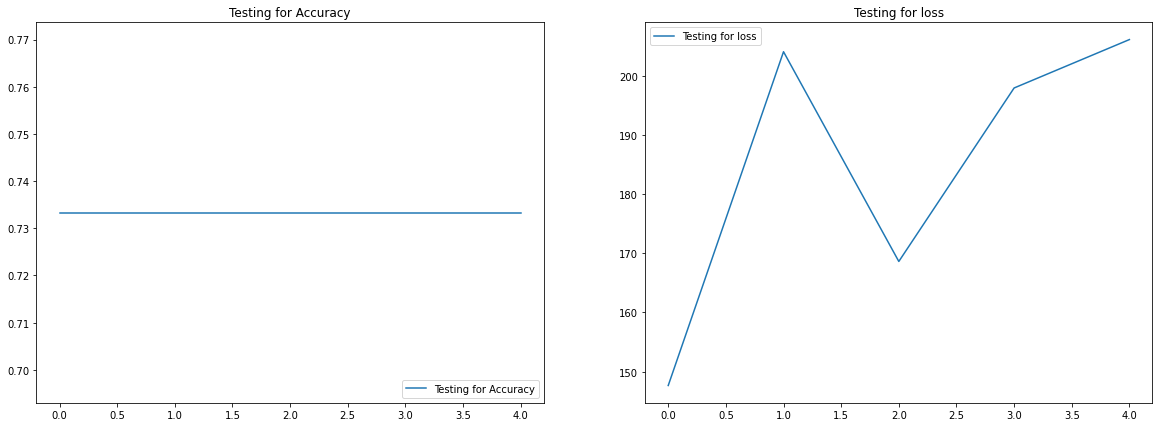

In [ ]:
accurate = history.history['accuracy']

loss = history.history['kl_loss']

epochs_range = range(5)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(epochs_range, accurate, label='Testing for Accuracy')
plt.legend(loc='lower right')
plt.title('Testing for Accuracy')


plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Testing for loss')
plt.legend(loc=' upper right')
plt.title('Testing for loss')
plt.show()